# MRI Dementia Classification - CNN Model
This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. All data sourced from https://www.kaggle.com/datasets/matthewhema/mri-dementia-augmentation-no-data-leak

In [6]:
# Import Dependencies and Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
# Load MRI Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

print("Path to dataset files:", path)

Path to dataset files: /Users/mattle/.cache/kagglehub/datasets/matthewhema/mri-dementia-augmentation-no-data-leak/versions/1


## Image Processing

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [8]:
# Set local data paths
train_dir = path + '/Train/Train'
val_dir = path + '/Val/Val'
test_dir = path + '/Test/Test'

# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255
}

In [9]:
# Image Generators Variables

# Resize all input images to 224x224
image_size = (224, 224)

#Number of images the model processes before updating weights
batch_size = 32

# Set the color space
color_mode = 'rgb'

# Define the class order
class_order = ['Non Demented', 'Very MildDemented', 'Mild Demented', 'Moderate Demented']

In [10]:
# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode=color_mode,
    classes=class_order,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    color_mode=color_mode,
    classes=class_order,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode=color_mode,
    classes=class_order,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)


Found 11350 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


In [11]:
# Check the class indices for each generator
train_class_indices = train_generator.class_indices
val_class_indices = val_generator.class_indices
test_class_indices = test_generator.class_indices

# Print the class indices
print("Train Class indices:", train_class_indices)
print("Validation Class indices:", val_class_indices)
print("Test Class indices:", test_class_indices)

# Check color space
print(train_generator.image_shape)  # should be (224, 224, 3)

Train Class indices: {'Non Demented': 0, 'Very MildDemented': 1, 'Mild Demented': 2, 'Moderate Demented': 3}
Validation Class indices: {'Non Demented': 0, 'Very MildDemented': 1, 'Mild Demented': 2, 'Moderate Demented': 3}
Test Class indices: {'Non Demented': 0, 'Very MildDemented': 1, 'Mild Demented': 2, 'Moderate Demented': 3}
(224, 224, 3)


---

## Create the Architecture of the Model 
In this section, simply uncomment the block of code (/ + CMND) for which version of the model you want to run. Be sure to change the version number when saving the filenames down below

### CNN Model sequential_3_model_V1 // F1 Score 0.51
Start with a basic Convcoluation layer and dense layer

In [12]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


### CNN Model sequential_4_model_V2 // F1 Score 0.96
Add another convolution layer and dense later doubling the number of neurons. 
Even with a high F1 score, there were some suspicious results when trying to test the model on individual MRI images. It was found out that the class_order wasn't in the right order so we corrected that in V3.

In [13]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_3_model_V3 // F1 Score 0.37
Corrected the class order and changed to gray scale. This yielded a way lower F1 score probabably due changing the color_mode to grayscale. Grayscale doesn't provide enough meaningful data to pull out the minute features to actually create an accurate model.

In [14]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_4_model_V4 // F1 Score 0.40
Went back to colorspace rgb. Kept the same CNN model configuration. After training the model and running it on the test data, it yielded a way lower F1 score than an accuracy score of 0.98. There's a -39% difference. This is probably due to the the imbalance of test data which is supposedly common with medical imaging. In this case non demented dominates the dataset so that could be contributing to the high accuracy. 

Also since we moved to a more ordinal encoding of the class labels, this imbalance is seen even more. 

In [15]:
# Build the CNN Model from scratch
model = Sequential([
    # Input Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    # Hidden Layers
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening Layer and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### VGG-16 // F1 Score 0.56
Just for fun, we try leveraging an existing model (VGG-16) that specializes in image classificaion.

VGG-16 is an existing Convolutional Neural Network (CNN) proposed by the Visual Geometry Group (VGG) at the University of Oxford consisting of 16 layers, including convolutional, pooling, and fully connected layers. For details of this model go to: https://www.geeksforgeeks.org/vgg-16-cnn-model/

In [16]:
# from tensorflow.keras.applications import VGG16

# # Build a Transfer Learning Model
# base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
# base_model.trainable = False  # Freeze base

# # Build the custom classifier
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(), # Reduces output to 1D vector
#     Dense(256, activation='relu'), # Fully connected layer with ReLU
#     Dense(512, activation='relu'), # 2nd connected layer with ReLU
#     Dropout(0.5), # Randomly turn off 50% of neurons to prevent overfitting
#     Dense(4, activation='softmax')  # Final output layer for 4 classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [17]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,378,308 (85.37 MB)

 Trainable params: 22,378,308 (85.37 MB)

 Non-trainable params: 0 (0.00 B)

---

## Train the Model

In [18]:
%%time
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


355/355 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4753 - loss: 6.3608 - val_accuracy: 0.5219 - val_loss: 1.0430
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.7598 - loss: 0.5436 - val_accuracy: 0.7625 - val_loss: 0.6053
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8608 - loss: 0.3367 - val_accuracy: 0.8490 - val_loss: 0.4094
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 343s 967ms/step - accuracy: 0.9098 - loss: 0.2185 - val_accuracy: 0.8906 - val_loss: 0.2959
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 308s 866ms/step - accuracy: 0.9498 - loss: 0.1409 - val_accuracy: 0.9344 - val_loss: 0.2151
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 323s 910ms/step - accuracy: 0.9554 - loss: 0.1171 - val_accuracy: 0.9646 - val_loss: 0.1462
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - accuracy: 0.9720 - loss: 0.0791 - val_accuracy: 0.9417 - val_loss: 0.1573
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1162s 3s/step - accuracy: 0.9776 - loss: 0.0639 - val_accur

### Run the Model on Test data

In [30]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9631 - loss: 0.1235
Test Accuracy: 0.96
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
CPU times: user 52.7 s, sys: 4.26 s, total: 56.9 s
Wall time: 8.9 s


### Analysis of Results

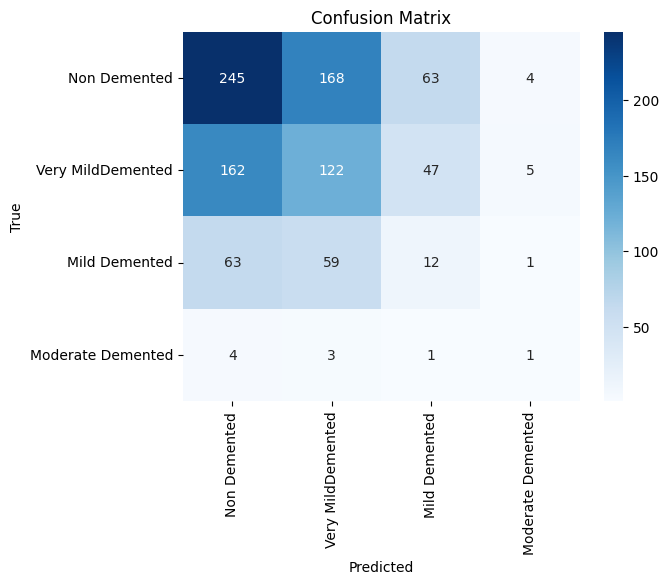

              precision    recall  f1-score   support

           0       0.52      0.51      0.51       480
           1       0.35      0.36      0.35       336
           2       0.10      0.09      0.09       135
           3       0.09      0.11      0.10         9

    accuracy                           0.40       960
   macro avg       0.26      0.27      0.27       960
weighted avg       0.39      0.40      0.39       960



In [29]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes))

In [32]:
# Print the number of images in each class - non and very mild are weighing the dataset down. 
import collections
print(collections.Counter(test_generator.classes))

Counter({np.int32(0): 480, np.int32(1): 336, np.int32(2): 135, np.int32(3): 9})


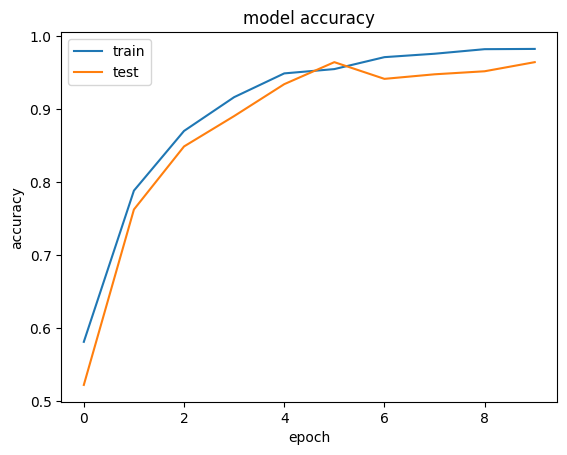

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

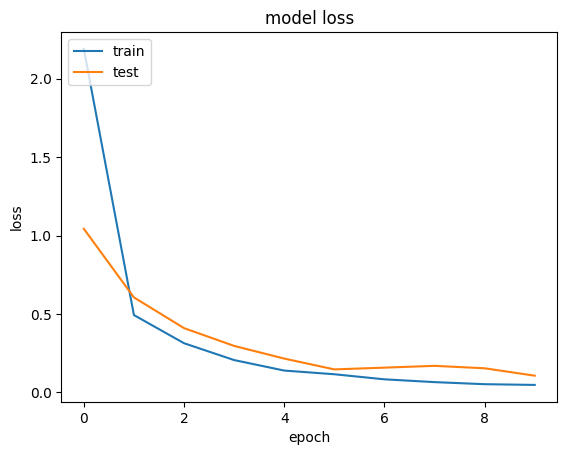

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Check class distributions

### Save the model and history into their respective files (keras and pickle)

In [23]:
# Create varibles to store the file names of the model and history 
model_name = model.name

# Set the version of the model
version = 'V4'

model_fullfilename = 'dementia_cnn_' + model_name + '_model_' + version + '.keras'
history_fullfilename = 'dementia_cnn_' + model_name + '_history_' + version + '.pkl'

print(model_fullfilename)
print(history_fullfilename)

dementia_cnn_sequential_model_V4.keras
dementia_cnn_sequential_history_V4.pkl


In [24]:
# Save the model into an .keras file
model.save('saved_models/' + model_fullfilename)

# Save the history object into a pickle file
import pickle

with open('saved_models/' + history_fullfilename, 'wb') as file:
    pickle.dump(history.history, file)